In [ ]:
sandbox =
PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Información sobre los datos

* Encounter ID 
    - ID único de la admisión de un paciente
* Patient number 
    - ID único de paciente
* Race 
    - Raza
* Gender
    - Sexo
* Age
    - Edad (en intervalos de 10 años)
    
* Weight
    - Peso en libras
* Admission type 
    - Identificador del tipo de admisión 
* Discharge disposition
    - Identificador del tipo de alta 
* Admission source
    - Identificador de la fuente de admisión 
* Time in hospital 
    - Número de días que han pasado entre admission y discharge (admisión y alta)
* Payer code
    - Identificador del código de pago
* Medical specialty
    - Identificador de la especialidad médica donde es ingresado el paciente
* Number of lab procedures 
    - Número de análisis en laboratorio que se han llevado a cabo durante el ingreso del paciente
* Number of procedures 
    - Número de procedimientos (diferentes a los análisis en laboratorio) que se han llevado a cabo durante el ingreso del paciente
* Number of medications
    - Número de nombres de medicamentos distintos que se hayan administrado al paciente durante su ingreso
* Number of outpatient visits
    - Número de visitas como paciente externo (no ingresado, por ejemplo) que ha tenido el paciente durante el año antes de esta admisión
* Number of emergency
    - Numero de visitas de emergencia del paciente durante el año antes de esta admisión
* Number of inpatient visits 
    - Número de visitas en las que ha estado ingresado el paciente durante el año antes de esta admisión
* Diagnosis 1 
    - Diagnóstico primario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 2 
    - Diagnóstico secundario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 3 
    - Diagnóstico adicional (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Number of diagnoses 
    - Número de diagnósticos que se han introducido al sistema
* Glucose serum test result 
    - Indica el rango del resultado de la prueba de glucosa, o si no se llevó a cabo la prueba. Valores: “>200,” “>300,” “normal,” y “none” si no se realizó la prueba
* A1c test result
    - Indica el rango del resultado de la prueba de hemoglobina A1c, o si no se llevó a cabo la prueba. Valores: “>8” si el resultado fue mayor del 8%, “>7” si el resultado fue mayor del 7% pero menor del 8%, “normal” si el resultado fue menor del 7%, y “none” si no se realizó la prueba.
* Change of medications 
    - Indica si ha habido un cambio en la medicación para la diabetes (tanto en la dosis como en el propio medicamento)
* Diabetes medications 
    - Indica si ha el paciente toma medicación para la diabetes
* 24 features for medications
    - Para los nombres genéricos de los medicamentos metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiridepioglitazone, metformin-rosiglitazone, y metforminpioglitazone, la variable indica si se prescribió o no el medicamento durante la visita del paciente
    - Valores: “up” si se subió la dosis durante la visita, “down” si se bajó la dosis, “steady” si la dosis no cambió, y “no” si no se prescribió el medicamento
* Readmitted 
    - Indica cuántos días ha tardado el paciente en volver al hospital y ser readmitido. Valores: “<30” si el paciente fue readmitido en menos de 30 días, “>30” si el paciente fue readmitido en más de 30 días, y “No” si el paciente no ha sido readmitido



## Cargar librerías

In [3]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans



## Lectura de datos

In [103]:
diabetes = pd.read_csv('diabetic_data.csv', sep=',')
admission_source = pd.read_csv('admission_source_id.csv', sep=',')
admission_type = pd.read_csv('admission_type_id.csv', sep=',')
discharge_disposition = pd.read_csv('discharge_disposition_id.csv', sep=',')

In [104]:
diabetes.columns=diabetes.columns.str.replace('-','_')



### comprobar correcta lectura de los datos

Realizamos con un head que revisar los encabezados de las bases. y que hayan cargado correctamente.

In [5]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
admission_source.head()

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [7]:
admission_type.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [8]:
discharge_disposition.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution




### juntar todos los datos en el mismo DataFrame

In [105]:
diabete_adm=diabetes.merge(admission_source, left_on='admission_source_id', right_on='admission_source_id', how='left',suffixes=('_original1','_admission'))

In [106]:
dia_adm_dis = diabete_adm.merge(discharge_disposition, left_on='discharge_disposition_id', right_on='discharge_disposition_id', how='left',suffixes=('_admission','_discharge'))

In [49]:
dia_adm_dis.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_admission,description_discharge
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Physician Referral,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency Room,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency Room,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Discharged to home


In [107]:
data = dia_adm_dis.merge(admission_type, left_on='admission_type_id', right_on='admission_type_id', how='left',suffixes=('_discharge','_adtype'))



### estudiar las dimensiones del dataset

Se agregaron 3 columnas de descripción para un total de 53 columnas y 101.766 registros.

In [33]:
data.shape

(101766, 53)

In [75]:
data.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         



## Data Wrangling



### cambiar los nombres de las columnas para que cumplan buenas prácticas (Dani)



### estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno (ok)

In [51]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_admission,description_discharge,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Physician Referral,Not Mapped,None
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency Room,Discharged to home,Emergency
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency Room,Discharged to home,Emergency
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Discharged to home,Emergency
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency Room,Discharged to home,Emergency




### estudiar si hay registros repetidos(ok)

---



In [19]:
data.duplicated().any()

False



### estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

*Se verificará el atributo unique que sea = 1 dentro del data.describe*

In [11]:
data.describe(include='all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted,description_admission,description_discharge,description
count,4.411000e+04,4.411000e+04,44110,44110,44110,44110,44110.000000,44110.000000,44110.000000,44110.000000,44110,44110,44110.000000,44110.000000,44110.000000,44110.000000,44110.000000,44110.000000,44110,44110,44110,44110.000000,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44110,44109,44110,44110,44110
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,16,64,NaN,NaN,NaN,NaN,NaN,NaN,630,609,653,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,3,3,2,3,1,1,4,4,2,1,1,1,2,2,3,12,24,7
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,?,?,NaN,NaN,NaN,NaN,NaN,NaN,414,250,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency Room,Discharged to home,Emergency
freq,NaN,NaN,31490,23799,11618,42406,NaN,NaN,NaN,NaN,30878,14852,NaN,NaN,NaN,NaN,NaN,NaN,3503,3034,5546,NaN,39526,36998,36130,43606,43904,44044,42171,44109,38346,38409,44094,41539,41136,43992,44095,44107,44079,44110,44110,22834,43979,44107,44110,44110,44110,26342,32977,24222,20682,25929,21211
mean,7.481923e+07,3.270408e+07,NaN,NaN,NaN,NaN,2.268284,4.390070,6.534437,4.576740,NaN,NaN,43.108093,1.387577,15.298708,0.218159,0.117116,0.592133,NaN,NaN,NaN,6.812922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.574129e+07,3.402587e+07,NaN,NaN,NaN,NaN,1.656407,6.164643,4.929789,3.101507,NaN,NaN,19.097930,1.699393,8.130653,0.881051,0.616801,1.208829,NaN,NaN,NaN,2.030053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.607805e+07,4.849060e+06,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.631726e+07,2.294122e+07,NaN,NaN,NaN,NaN,2.000000,1.000000,7.000000,4.000000,NaN,NaN,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.049085e+08,5.523694e+07,NaN,NaN,NaN,NaN,3.000000,5.000000,7.000000,6.000000,NaN,NaN,56.000000,2.000000,19.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.nunique()==1

encounter_id                False
patient_nbr                 False
race                        False
gender                      False
age                         False
weight                      False
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
payer_code                  False
medical_specialty           False
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                      False
diag_2                      False
diag_3                      False
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide 

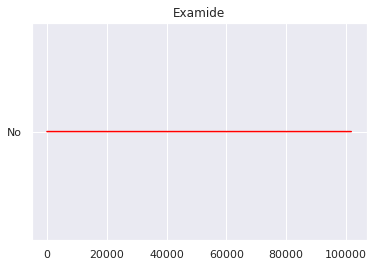

In [66]:
#examide	citoglipton
#data['examide']
plt.plot(data['examide'], 'red')
plt.title('Examide')
plt.show()

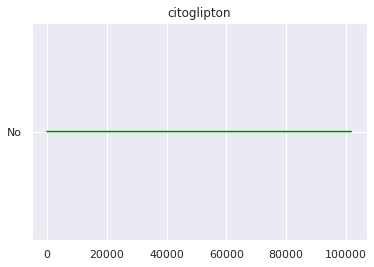

In [67]:
plt.plot(data['citoglipton'], 'green')
plt.title('citoglipton')
plt.show()

In [108]:
#borramos las dos columnas sin variabilidad.
data.drop(['examide','citoglipton'], axis=1,inplace=True) # no tienen variabilidad.



### estudiar los nulos en el dataset

In [22]:
data.isnull().any()

encounter_id                False
patient_nbr                 False
race                        False
gender                      False
age                         False
weight                      False
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
payer_code                  False
medical_specialty           False
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                      False
diag_2                      False
diag_3                      False
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide 

NO se observaban valores nulos, luego realizamos una segunda revisión con los valores de cada categoria.

Verificamos cuantos valores distintos hay por variable.

In [15]:
for col in data.columns:
  print(data 
  .groupby(col)
  .agg(frequency=(col, "count")))


              frequency
encounter_id           
12522                 1
15738                 1
16680                 1
28236                 1
35754                 1
...                 ...
443847548             1
443847782             1
443854148             1
443857166             1
443867222             1

[101766 rows x 1 columns]
             frequency
patient_nbr           
135                  2
378                  1
729                  1
774                  1
927                  1
...                ...
189351095            1
189365864            1
189445127            1
189481478            1
189502619            1

[71518 rows x 1 columns]
                 frequency
race                      
?                     2273
AfricanAmerican      19210
Asian                  641
Caucasian            76099
Hispanic              2037
Other                 1506
                 frequency
gender                    
Female               54708
Male                 47055
Unknown/Inva

In [109]:
data = data.replace('?',np.nan)

In [110]:
data.drop(data[data['gender']=='Unknown/Invalid'].index,inplace=True)




### crear variables dummy en caso que sea conveniente

Al momento de modelar se crearan las variables dummy necesarias



### estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

Reemplazamos las variables ausentes denotadas con '?' con missing.

In [14]:
categoricas = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       #muy poca variabilidad.
       #'glyburide_metformin', 
       #'glipizide_metformin',
       #'glimepiride_pioglitazone', 
       #'metformin_rosiglitazone',
       #'metformin_pioglitazone',
        'change', 'diabetesMed','payer_code','medical_specialty']

In [50]:
data[categoricas].isnull().sum()

race                  2271
gender                   0
max_glu_serum            0
A1Cresult                0
metformin                0
repaglinide              0
nateglinide              0
chlorpropamide           0
glimepiride              0
acetohexamide            0
glipizide                0
glyburide                0
tolbutamide              0
pioglitazone             0
rosiglitazone            0
acarbose                 0
miglitol                 0
troglitazone             0
tolazamide               0
insulin                  0
change                   0
diabetesMed              0
payer_code           40255
medical_specialty    49947
dtype: int64

In [15]:
cols_num = ['time_in_hospital',
'num_lab_procedures',
'num_procedures',
'num_medications',
'number_outpatient',
'number_emergency',
'number_inpatient',
'number_diagnoses']

In [23]:
data[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

A partir del análisis de las columnas, podemos ver que hay una combinación de datos categóricos (no numéricos) y numéricos. Algunas cosas para señalar,

- find_id y patient_nbr: estos son solo identificadores y no variables útiles
- edad y peso: son categóricos en este conjunto de datos
- id_tipo_de_admisión, id_disposición_descarga, id_fuente_admisión: son numéricos aquí, pero son categorias. Deben considerarse categóricos.

- medical_speciality - tiene muchas variables categóricas, por lo que deberíamos considerar esto al crear características.


## estudiar los outliers

In [111]:
def tukey_outliers(data,column,extreme=False):
    q1, q3 = np.percentile(data[column],[25,75])
    iqr = q3 - q1
    constant = 5 if not extreme else 10
    return data[~((data[column]>(q3+constant*iqr)) | (data[column]<(q1-constant*iqr)))]

Se utiliza el método de tukey par identificar outliers pero que esten 10 por fuera del rango intercuartilico.

In [112]:


df2 = tukey_outliers(data,'num_procedures',extreme=True)
df3 = tukey_outliers(df2,'num_medications',extreme=True)
df4 = tukey_outliers(df3,'time_in_hospital',extreme=True)
df5 = tukey_outliers(df4,'number_inpatient',extreme=True)
df6 = tukey_outliers(df5,'number_emergency',extreme=True) #borra toda la data
df7 = tukey_outliers(df6,'number_diagnoses',extreme=True)
df8 = tukey_outliers(df7,'num_lab_procedures',extreme=True)
df9 = tukey_outliers(df8,'number_outpatient',extreme=True)

print(f'without number_outpatient: {df9.shape}')
print(f'without num_lab_procedures: {df8.shape}')
print(f'without number_diagnoses: {df7.shape}')
print(f'without number_emergency: {df6.shape}')
print(f'without number_inpatient: {df5.shape}')
print(f'without time_in_hospital: {df4.shape}')
print(f'without num_medications: {df3.shape}')
print(f'without num_procedures: {df2.shape}')
print(f'original: {data.shape}')

without number_outpatient: (77564, 51)
without num_lab_procedures: (90358, 51)
without number_diagnoses: (90358, 51)
without number_emergency: (90358, 51)
without number_inpatient: (101679, 51)
without time_in_hospital: (101763, 51)
without num_medications: (101763, 51)
without num_procedures: (101763, 51)
original: (101763, 51)


In [113]:
# Data filtrada final

age_id = {'[0-10)':'g0', 
          '[10-20)':'g10', 
          '[20-30)':'g20', 
          '[30-40)':'g30', 
          '[40-50)':'g40', 
          '[50-60)':'g50',
          '[60-70)':'g60', 
          '[70-80)':'g70', 
          '[80-90)':'g80', 
          '[90-100)':'g90'}
data['age_group'] = data.age.replace(age_id)




Creamos la base ya filtrada sin atipicos

In [19]:
data=df8.copy()

In [54]:
data.shape

(90358, 53)



### antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

In [55]:
data.groupby('medical_specialty').size().sort_values(ascending=False).head(15)

medical_specialty
InternalMedicine                   13164
Family/GeneralPractice              6513
Emergency/Trauma                    6146
Cardiology                          5033
Surgery-General                     2723
Orthopedics                         1350
Nephrology                          1322
Orthopedics-Reconstructive          1169
Radiologist                         1052
Pulmonology                          788
Psychiatry                           752
ObstetricsandGynecology              638
Surgery-Cardiovascular/Thoracic      633
Urology                              631
Gastroenterology                     529
dtype: int64

In [114]:
#NOs quedamos con las 5 razones más frecuentes de ingreso
ingresos_5 = ['InternalMedicine',
'Family/GeneralPractice',
'Emergency/Trauma',       
'Cardiology',
'Surgery-General']

data['ingresos_medicos'] = data['medical_specialty'].copy()


data.loc[~data.ingresos_medicos.isin(ingresos_5),'ingresos_medicos'] = 'Otros'

In [58]:
(data 
  .groupby("ingresos_medicos")
  .agg(frequency=("ingresos_medicos", "count")))

,frequency
ingresos_medicos,
Cardiology,5033
Emergency/Trauma,6146
Family/GeneralPractice,6513
InternalMedicine,13164
Otros,56779
Surgery-General,2723


Eliminamos columnas sin variables.

In [21]:
data.drop(['glyburide_metformin', 
 'glipizide_metformin',
 'glimepiride_pioglitazone',
 'metformin_rosiglitazone',
 'metformin_pioglitazone'
 ], axis=1,inplace=True) # no tienen variabilidad.





# Exploratory Data Analysis

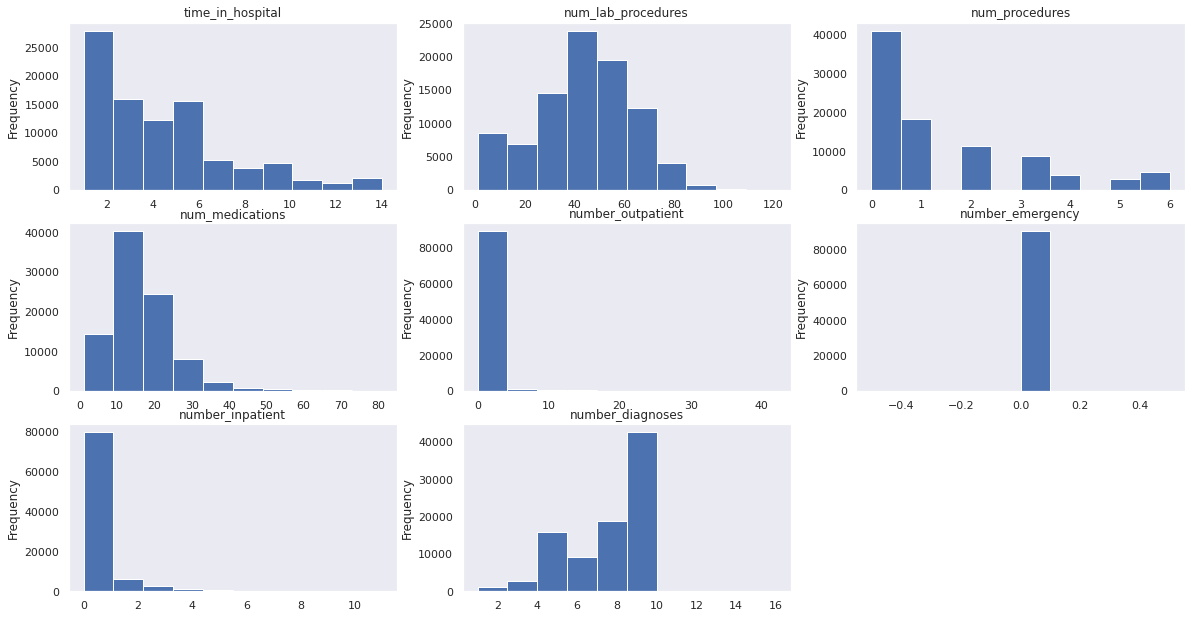

In [61]:
#las 3 primeras variables son númericas pero representan categorias.
numericas = [#'admission_type_id',
 #'discharge_disposition_id',
 #'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

fig = plt.figure(figsize=(20, 40))
for i, sc in enumerate(numericas):
    fig.add_subplot(11, 3, i+1)
    ax = data[sc].plot(kind='hist')
    ax.set_title(sc)
    ax.grid()
   
plt.show()



### crear la matriz de correlación

In [152]:
data.corr()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age_group
encounter_id,1.000000,0.521559,-0.141445,-0.137074,-0.103848,-0.067075,-0.044274,-0.008668,0.076825,0.099730,NaN,-0.000802,0.263435,0.087837
patient_nbr,0.521559,1.000000,0.008200,-0.139268,-0.019551,-0.028541,-0.004718,-0.013178,0.021946,0.099866,NaN,-0.014645,0.226351,0.086041
admission_type_id,-0.141445,0.008200,1.000000,0.078120,0.083013,-0.012741,-0.132346,0.132876,0.086432,0.039969,NaN,-0.032224,-0.119022,-0.011155
discharge_disposition_id,-0.137074,-0.139268,0.078120,1.000000,0.009984,0.164160,0.028230,0.015243,0.109288,-0.007556,NaN,0.033075,0.046696,0.108030
admission_source_id,-0.103848,-0.019551,0.083013,0.009984,1.000000,-0.006549,0.072964,-0.138322,-0.060468,0.020673,NaN,0.017308,0.071739,0.053479
time_in_hospital,-0.067075,-0.028541,-0.012741,0.164160,-0.006549,1.000000,0.324461,0.185799,0.461776,-0.013186,NaN,0.085721,0.221630,0.108419
num_lab_procedures,-0.044274,-0.004718,-0.132346,0.028230,0.072964,0.324461,1.000000,0.050930,0.265314,-0.016835,NaN,0.042823,0.146978,0.021503
num_procedures,-0.008668,-0.013178,0.132876,0.015243,-0.138322,0.185799,0.050930,1.000000,0.390562,-0.020306,NaN,-0.066489,0.074567,-0.036355
num_medications,0.076825,0.021946,0.086432,0.109288,-0.060468,0.461776,0.265314,0.390562,1.000000,0.041401,NaN,0.055385,0.260378,0.044048
number_outpatient,0.099730,0.099866,0.039969,-0.007556,0.020673,-0.013186,-0.016835,-0.020306,0.041401,1.000000,NaN,0.089022,0.088055,0.036996




### pintar la matriz de correlación

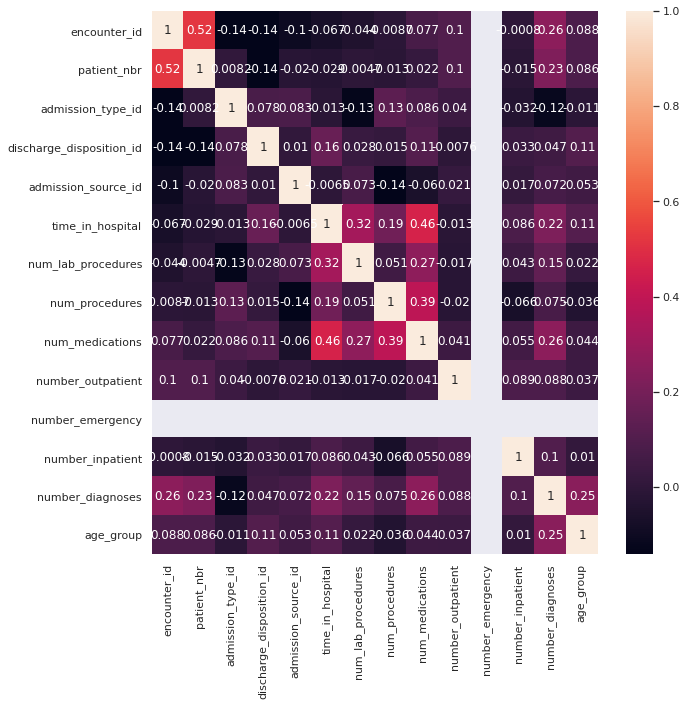

In [159]:
fig, ax = plt.subplots(figsize=(10,10))    
sns.heatmap(data.corr(), annot = True,ax=ax)
plt.show()


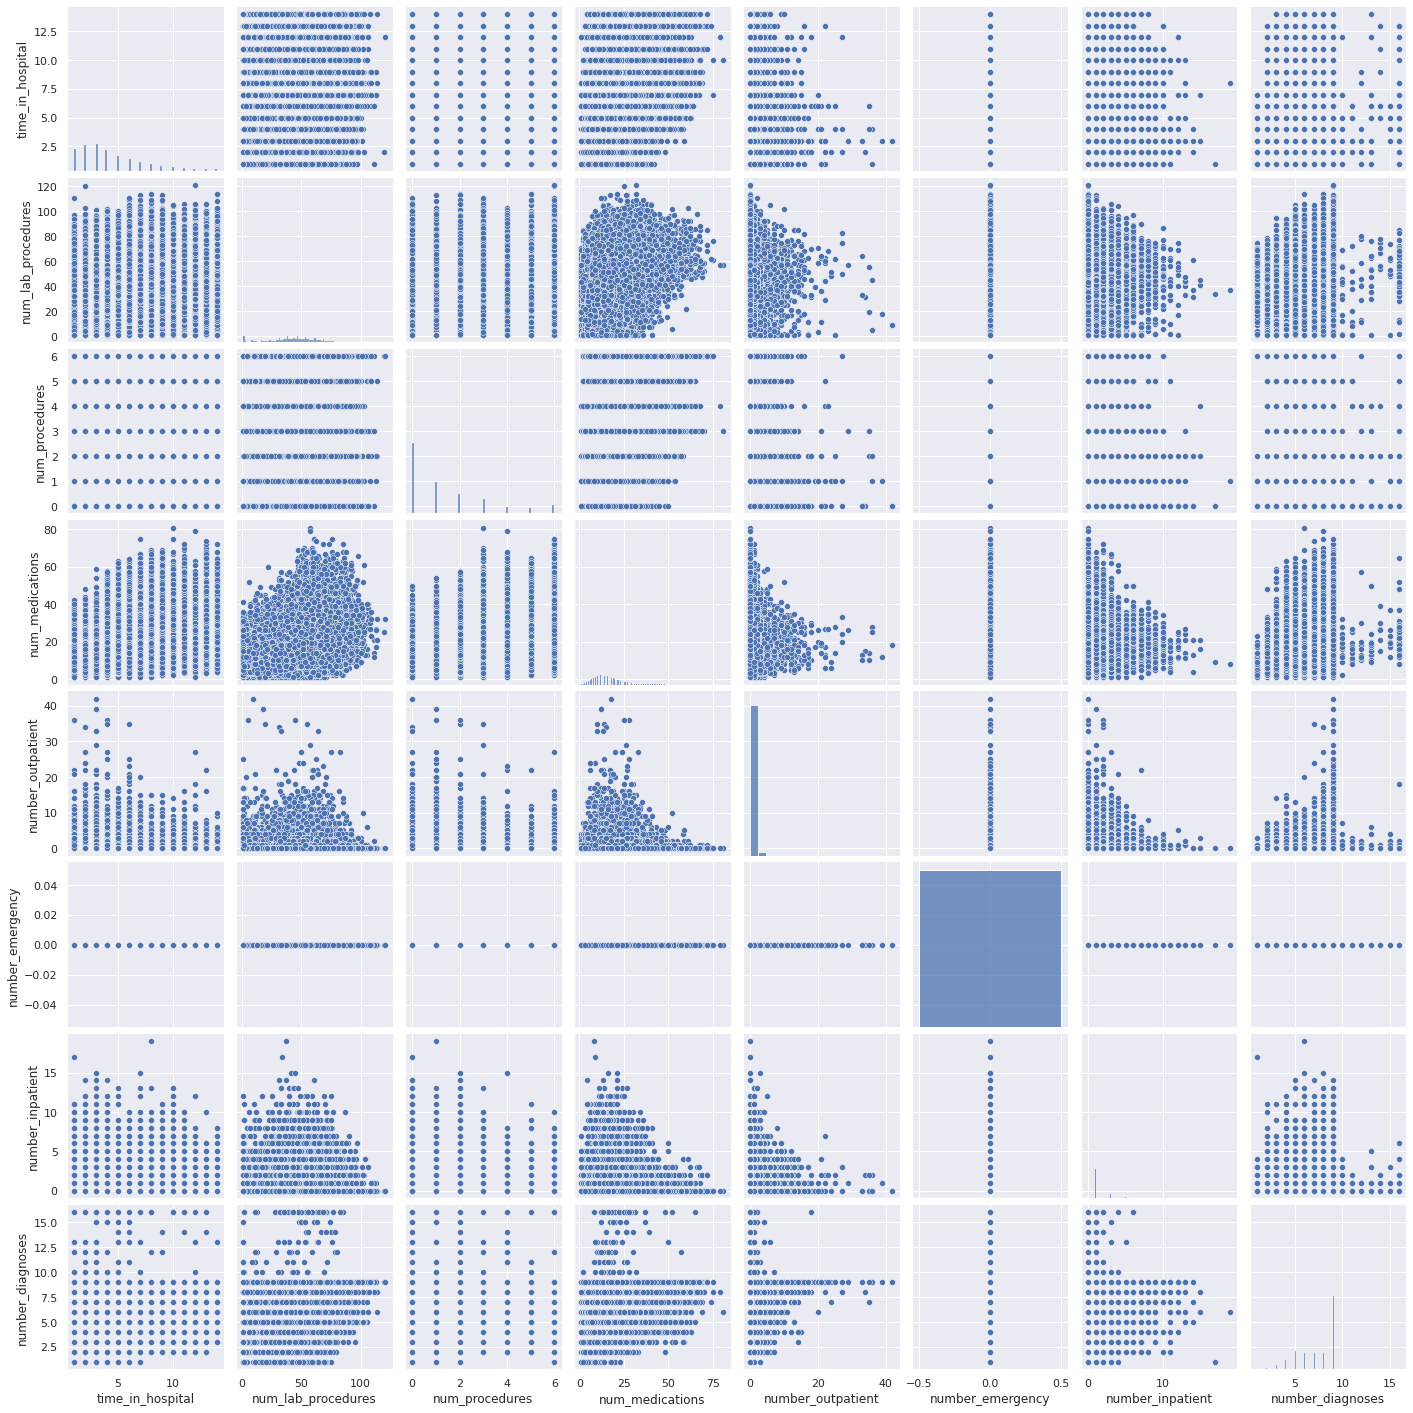

In [160]:
sns.pairplot(data[numericas])



### determinar qué par de variables están correlacionadas

*Las 2 variables cuantitativas con mayor correlación son número de medicamentos (num_medications) y tiempo en el hospital (time_in_hospital) con un coeficiente de correlación de 0.46*




### estudiar los pares de variables correlacionadas para quedarse solamente con una del par

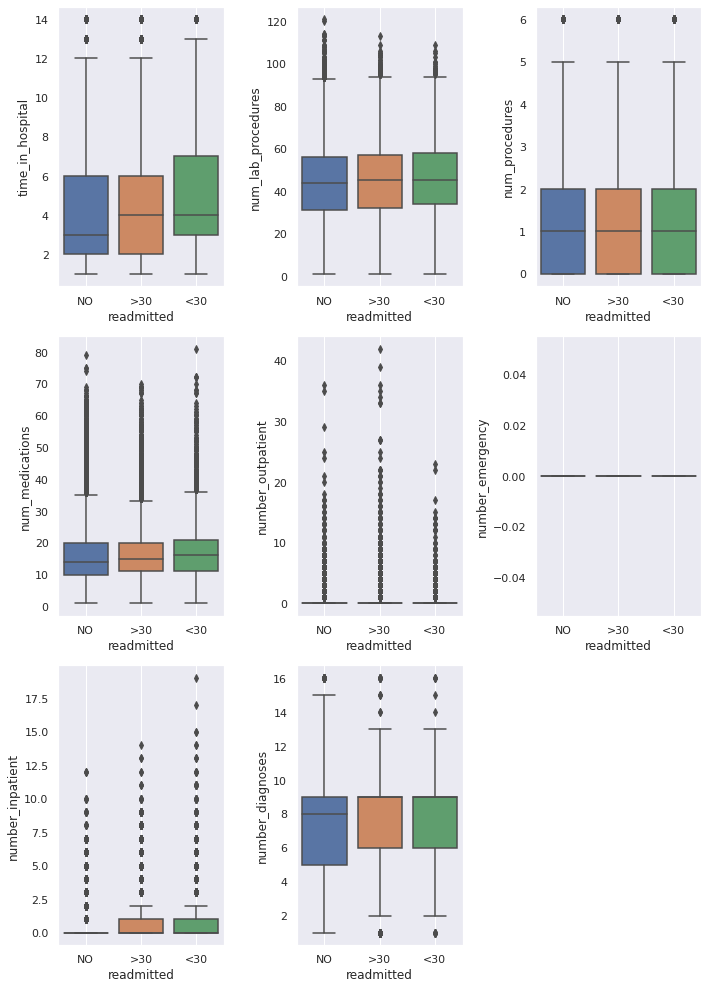

In [161]:
numericas = [ 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

fig = plt.figure(figsize=(10, 50))
for i, sc in enumerate(numericas):
    fig.add_subplot(11, 3, i+1)
    ax = sns.boxplot(x='readmitted',y=sc,data=data)
    #ax.set_title(sc)
    
    ax.grid()
plt.tight_layout() 
#plt.show()
#ax = sns.boxplot(x="gender", y="time_in_hospital", data=data)

# Elección variable

In [117]:
data['y'] = (data.readmitted == '<30').astype('int')
pd.crosstab(index=data['y'],
            columns=data['readmitted'], margins=True)



readmitted,<30,>30,NO,All
y,,,,
0,0,35545,54861,90406
1,11357,0,0,11357
All,11357,35545,54861,101763


In [59]:
print(f'''Población que ha vuelto a ser readmitida: {sum(data['y'])/len(data['y'])*100:,.2f}%''')

Población que ha vuelto a ser readmitida: 10.46%


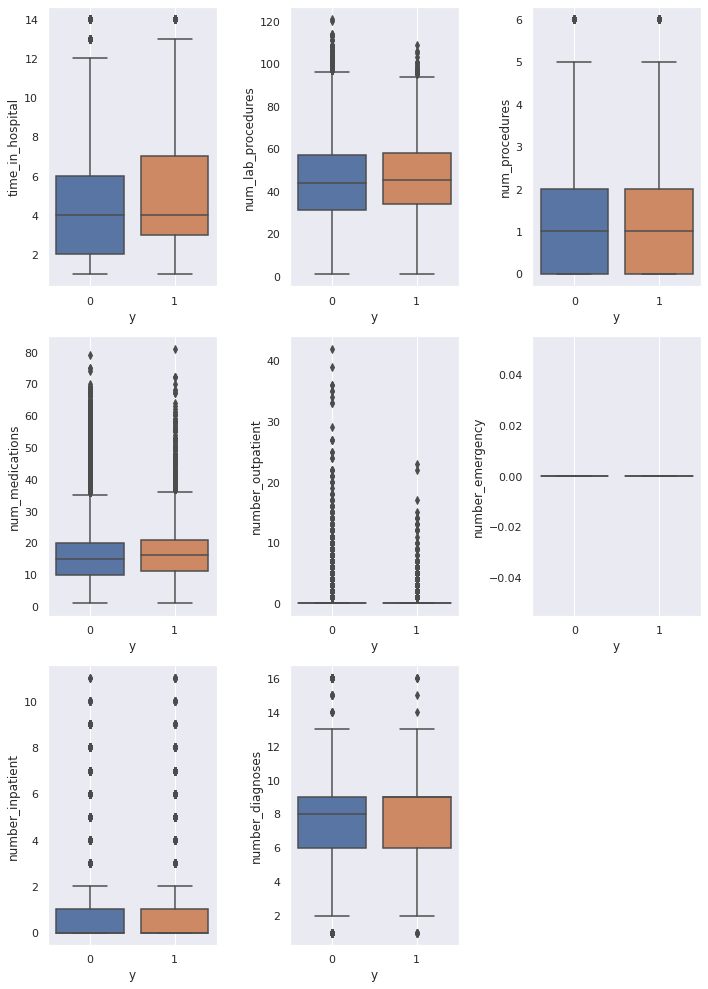

In [64]:

fig = plt.figure(figsize=(10, 50))
for i, sc in enumerate(numericas):
    fig.add_subplot(11, 3, i+1)
    ax = sns.boxplot(x='y',y=sc,data=data)
    #ax.set_title(sc)
    ax.grid()
plt.tight_layout() #ajustar las graficas al espacio.



# Modelado

In [65]:
data.shape

(90358, 51)

In [181]:
variables_final = ['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses','gender',
                   'rosiglitazone',
                   'repaglinide',
                   'nateglinide',
                   'age_group',
                   'ingresos_medicos','y']

In [182]:
variables_dummie=pd.get_dummies(data[variables_final]).columns

In [188]:
data_filtrada=pd.get_dummies(data[variables_final])

In [183]:
variables_dummie

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'y', 'gender_Female',
       'gender_Male', 'rosiglitazone_Down', 'rosiglitazone_No',
       'rosiglitazone_Steady', 'rosiglitazone_Up', 'repaglinide_Down',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_Down', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'age_group_g0', 'age_group_g10', 'age_group_g20',
       'age_group_g30', 'age_group_g40', 'age_group_g50', 'age_group_g60',
       'age_group_g70', 'age_group_g80', 'age_group_g90',
       'ingresos_medicos_Cardiology', 'ingresos_medicos_Emergency/Trauma',
       'ingresos_medicos_Family/GeneralPractice',
       'ingresos_medicos_InternalMedicine', 'ingresos_medicos_Otros',
       'ingresos_medicos_Surgery-General'],
      dtype='object')



### seleccionar variables

In [184]:
def ratio(y_actual):
    return (sum(y_actual)/len(y_actual))

In [122]:
print('ratio de reingreso:%.3f'%ratio(data['y'].values))

ratio de reingreso:0.112


EN los primeros modelos realizados encontramos un recall de 0 para nuestra variable target y Como los datos estan desbalanceados realizamos un submuestreo.

In [189]:
malos = data_filtrada.y == 1
data_train_pos = data_filtrada.loc[malos]
data_train_neg = data_filtrada.loc[~malos]

# fusionar los datos balanceados
data_train = pd.concat([data_train_pos, data_train_neg.sample(n = len(data_train_pos), random_state = 3)],axis = 0)


In [190]:

# barajar el orden de las muestras de entrenamiento 
data_train = data_train.sample(n = len(data_train), random_state = 3).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(data_train), ratio(data_train.y.values)))


Train balanced prevalence(n = 22714):0.500


In [191]:
data_train.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'y', 'gender_Female',
       'gender_Male', 'rosiglitazone_Down', 'rosiglitazone_No',
       'rosiglitazone_Steady', 'rosiglitazone_Up', 'repaglinide_Down',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_Down', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'age_group_g0', 'age_group_g10', 'age_group_g20',
       'age_group_g30', 'age_group_g40', 'age_group_g50', 'age_group_g60',
       'age_group_g70', 'age_group_g80', 'age_group_g90',
       'ingresos_medicos_Cardiology', 'ingresos_medicos_Emergency/Trauma',
       'ingresos_medicos_Family/GeneralPractice',
       'ingresos_medicos_InternalMedicine', 'ingresos_medicos_Otros',
       'ingresos_medicos_Surgery-General'],
      dtype='object')

In [192]:
X=data_train[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'gender_Female',
       'gender_Male', 'rosiglitazone_Down', 'rosiglitazone_No',
       'rosiglitazone_Steady', 'rosiglitazone_Up', 'repaglinide_Down',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_Down', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'age_group_g0', 'age_group_g10', 'age_group_g20',
       'age_group_g30', 'age_group_g40', 'age_group_g50', 'age_group_g60',
       'age_group_g70', 'age_group_g80', 'age_group_g90',
       'ingresos_medicos_Cardiology', 'ingresos_medicos_Emergency/Trauma',
       'ingresos_medicos_Family/GeneralPractice',
       'ingresos_medicos_InternalMedicine', 'ingresos_medicos_Otros',
       'ingresos_medicos_Surgery-General']]
y=data_train[['y']]

Realizamos el particionamiento de los datos en Entrenamiento y validación.

In [193]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,y,age_group_g0,age_group_g10,age_group_g20,age_group_g30,age_group_g40,age_group_g50,age_group_g60,age_group_g70,age_group_g80,age_group_g90,ingresos_medicos_Cardiology,ingresos_medicos_Emergency/Trauma,ingresos_medicos_Family/GeneralPractice,ingresos_medicos_InternalMedicine,ingresos_medicos_Otros,ingresos_medicos_Surgery-General
75513,1,34,0,8,0,0,0,9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
26199,2,54,0,6,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7373,2,52,1,9,0,0,0,7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
93060,1,22,0,4,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
53236,6,49,0,11,1,0,1,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405,5,20,0,12,0,0,1,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
60006,2,35,3,21,0,0,1,8,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
85713,1,40,6,15,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
873,8,65,6,30,0,0,0,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0




### estandarizar variables

In [194]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [195]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [196]:
# cargarlo de nuevo
scaler = pickle.load(open(scalerfile, 'rb'))

In [197]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)



### lanzar distintos algoritmos

# K vecinos más cercanos (KNN)


In [198]:
# k
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_tf, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [199]:
 from sklearn.metrics import classification_report
 print(classification_report(y_train, knn.predict(X_train_tf)))
 roc_auc_score(y_train, knn.predict(X_train_tf))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      7588
           1       0.72      0.70      0.71      7630

    accuracy                           0.71     15218
   macro avg       0.71      0.71      0.71     15218
weighted avg       0.71      0.71      0.71     15218



0.7143853404458028

In [154]:
knn_train_auc= roc_auc_score(y_train, knn.predict(X_train_tf))
knn_valid_auc= roc_auc_score(y_valid, knn.predict(X_valid_tf))




### evaluar los algoritmos para determinar cuál es el que mejor

# Logistic regression

In [200]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 3,)
lr.fit(X_train_tf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
X_train

array([[ 1, 34,  0, ...,  0,  1,  0],
       [ 2, 54,  0, ...,  1,  0,  0],
       [ 2, 52,  1, ...,  0,  1,  0],
       ...,
       [ 1, 40,  6, ...,  0,  1,  0],
       [ 8, 65,  6, ...,  0,  0,  0],
       [ 4, 35,  6, ...,  0,  1,  0]])

In [201]:
 from sklearn.metrics import classification_report
 print(classification_report(y_train, lr.predict(X_train_tf)))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63      7588
           1       0.62      0.50      0.55      7630

    accuracy                           0.60     15218
   macro avg       0.60      0.60      0.59     15218
weighted avg       0.60      0.60      0.59     15218



In [202]:
lr_train_auc= roc_auc_score(y_train, lr.predict(X_train_tf))
lr_valid_auc= roc_auc_score(y_valid, lr.predict(X_valid_tf))

# Decision Tree Classifier

In [203]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 3)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')

In [204]:
 from sklearn.metrics import classification_report
 print(classification_report(y_train, tree.predict(X_train_tf)))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      7588
           1       0.68      0.62      0.65      7630

    accuracy                           0.67     15218
   macro avg       0.67      0.67      0.67     15218
weighted avg       0.67      0.67      0.67     15218



In [205]:

tree_train_auc= roc_auc_score(y_train, tree.predict(X_train_tf))
tree_valid_auc= roc_auc_score(y_valid, tree.predict(X_valid_tf))


# Random Forest

In [206]:

from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 3)
rf.fit(X_train_tf, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [207]:
 from sklearn.metrics import classification_report
 print(classification_report(y_train, rf.predict(X_train_tf)))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      7588
           1       0.63      0.58      0.60      7630

    accuracy                           0.62     15218
   macro avg       0.62      0.62      0.62     15218
weighted avg       0.62      0.62      0.62     15218



In [158]:
rf_train_auc= roc_auc_score(y_train, rf.predict(X_train_tf))
rf_valid_auc= roc_auc_score(y_valid, rf.predict(X_valid_tf))

In [208]:
 from sklearn.metrics import classification_report
 print(classification_report(y_valid, rf.predict(X_valid_tf)))

              precision    recall  f1-score   support

           0       0.59      0.63      0.61      3769
           1       0.60      0.56      0.58      3727

    accuracy                           0.60      7496
   macro avg       0.60      0.59      0.59      7496
weighted avg       0.60      0.60      0.59      7496



In [225]:
df_results = pd.DataFrame({'classifier':[ 'KNN','KNN','LR','LR','DT','DT','RF','RF'],
                           'data_set':['train','valid']*4,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,],
                          })
df_results

,classifier,data_set,auc
0,KNN,train,0.709870
1,KNN,valid,0.542289
2,LR,train,0.597521
3,LR,valid,0.595467
4,DT,train,0.666577
5,DT,valid,0.567622
6,RF,train,0.611590
7,RF,valid,0.589041


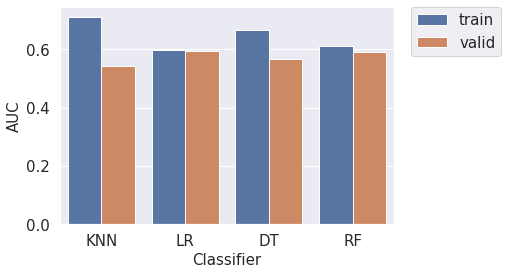

In [211]:
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Saca la leyenda de la figura
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

In [214]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

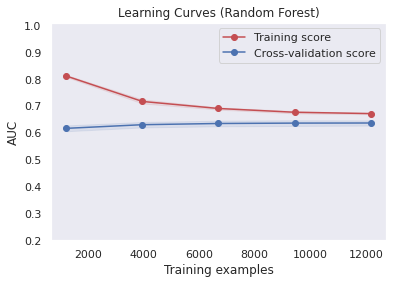

In [215]:

title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [177]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
  

La regresión logística es un modelo muy interpretable porque el coeficiente de cada variable muestra cuán importante es esa variable para la predicción. 

Donde número de ingresos es la variable más significativa.

In [178]:
feature_importances.head()

,importance
number_inpatient,0.420235
number_diagnoses,0.088848
num_medications,0.069693
time_in_hospital,0.059850
age_group_g70,0.045075


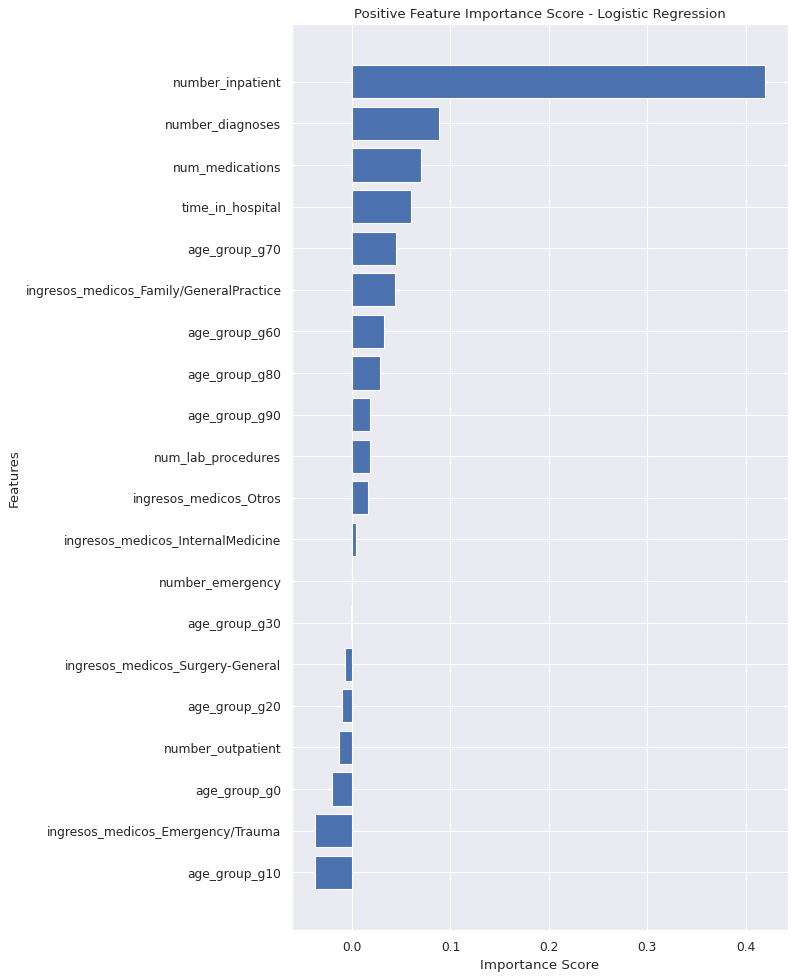

In [224]:
num = 20
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive -Negative  Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

Para la regresión logística, las variables con coeficientes positivos más altos predicen reingresos y las variables con coeficientes negativos más altos predicen no reingreso. 

# Insights:

- Habia información en missing encubierta con el signo de interrogación (?)

- La hipotesis que planteabamos era que el peso era una variable importante pero la descartamos por tener gran número de missing.

- number_outpatient tenia mucha información atipica luego no realizamos un filtro por esta variable dado que nos quedabamos con muy poca información


- A través de este proyecto, creamos un clasificador binario para predecir la probabilidad de que un paciente con diabetes sea readmitido en el hospital dentro de los 30 días. 

$Variable_{target} :   \begin{Bmatrix} 1 & <30 \text{ días} \\ 0 & e.o.c \end{Bmatrix} $

- En los datos de prueba disponibles, nuestro mejor modelo tuvo un AUC de 0,59. Con este modelo, podemos detectar el 59% de las readmisiones de nuestro modelo.

- Las variable más significativa fue número de visitas en el ultimo año.